In [50]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm

import csv
import os

import sys
sys.path.append("../stable_communities")

import nbimporter
from stable_communities import get_stable_communities_score


In [52]:
lat_min, lat_max = 30.4, 35.0
lon_min, lon_max = -85.6, -80.8
step = 0.01

In [56]:
output_file = "stable_communities_scores_nearby_0.01.csv"

In [57]:
# Write header if file doesn't exist yet
if not os.path.exists(output_file):
    with open(output_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["lon", "lat", "score", "score_type"])

# Your loop
for lat in tqdm(np.arange(lat_min, lat_max, step)):
    for lon in np.arange(lon_min, lon_max, step):
        try:
            score = get_stable_communities_score(lat, lon, score_type="use_nearby_tract")
            
            # Append result to CSV
            with open(output_file, mode="a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([lon, lat, score, "use_nearby_tract"])

        except Exception as e:
            print(f"Error at ({lat}, {lon}): {e}")

100%|██████████| 461/461 [4:49:43<00:00, 37.71s/it]  


In [ ]:
# points_nearby = []
# for lat in tqdm(np.arange(lat_min, lat_max, step)):
#     for lon in np.arange(lon_min, lon_max, step):
#         try:
#             score = get_stable_communities_score(lat, lon, score_type=score_type)
#             points_nearby.append((lon, lat, score))
#         except Exception as e:
#             print(f"Error at ({lat}, {lon}): {e}")


# df_nearby_tract = pd.DataFrame(points_nearby, columns=["lon", "lat", "score"])
# df_nearby_tract['score_type'] = 'use_nearby_tract'
# df_nearby_tract.to_csv("../../data/map/stable_communities/stable_communities_scores_nearby_tract.csv", index = False)

# df_actual_tract = pd.DataFrame(points, columns=["lon", "lat", "score"])
# df_actual_tract['score_type'] = 'use_only_actual_tract'
# df_actual_tract.to_csv("../../data/map/stable_communities/stable_communities_scores_actual_tract.csv", index = False)

# df_combined = pd.concat([df_actual_tract, df_nearby_tract], axis=0)

# df_wide = df_combined.pivot_table(
#     index=["lat", "lon"],
#     columns="score_type",
#     values="score"
# ).reset_index()


# df_wide["best_score"] = df_wide[["use_only_actual_tract", "use_nearby_tract"]].max(axis=1)

# df_wide.to_csv("../../data/map/stable_communities/stable_communities_scores_all.csv", index = False)

100%|██████████| 93/93 [11:40<00:00,  7.53s/it]


In [59]:
df_actual = pd.read_csv("../../data/map/stable_communities/stable_communities_scores_actual_0.01.csv")
df_nearby = pd.read_csv("../../data/map/stable_communities/stable_communities_scores_nearby_0.01.csv")

In [100]:
df_actual["lat"] = df_actual["lat"].astype(float).round(2)
df_actual["lon"] = df_actual["lon"].astype(float).round(2)

df_nearby["lat"] = df_nearby["lat"].astype(float).round(2)
df_nearby["lon"] = df_nearby["lon"].astype(float).round(2)

In [101]:
df_combined_2 = pd.concat([df_actual, df_nearby], axis=0)

In [102]:
df_wide = df_combined_2.pivot_table(
    index=["lat", "lon"],
    columns="score_type",
    values="score"
).reset_index()

In [104]:
df_wide["best_score"] = df_wide[["use_only_actual_tract", "use_nearby_tract"]].max(axis=1)

In [105]:
df_wide.to_csv("../../data/map/stable_communities/stable_communities_scores_all_0.01.csv", index = False)

In [106]:
gdf_wide = gpd.GeoDataFrame(
    df_wide,
    geometry=gpd.points_from_xy(df_wide.lon, df_wide.lat),
    crs="EPSG:4326"
).to_crs(epsg=3857)

In [118]:
ga_tracts = gpd.read_file("../../data/raw/shapefiles/tl_2024_13_tract/tl_2024_13_tract.shp").to_crs(epsg=3857)

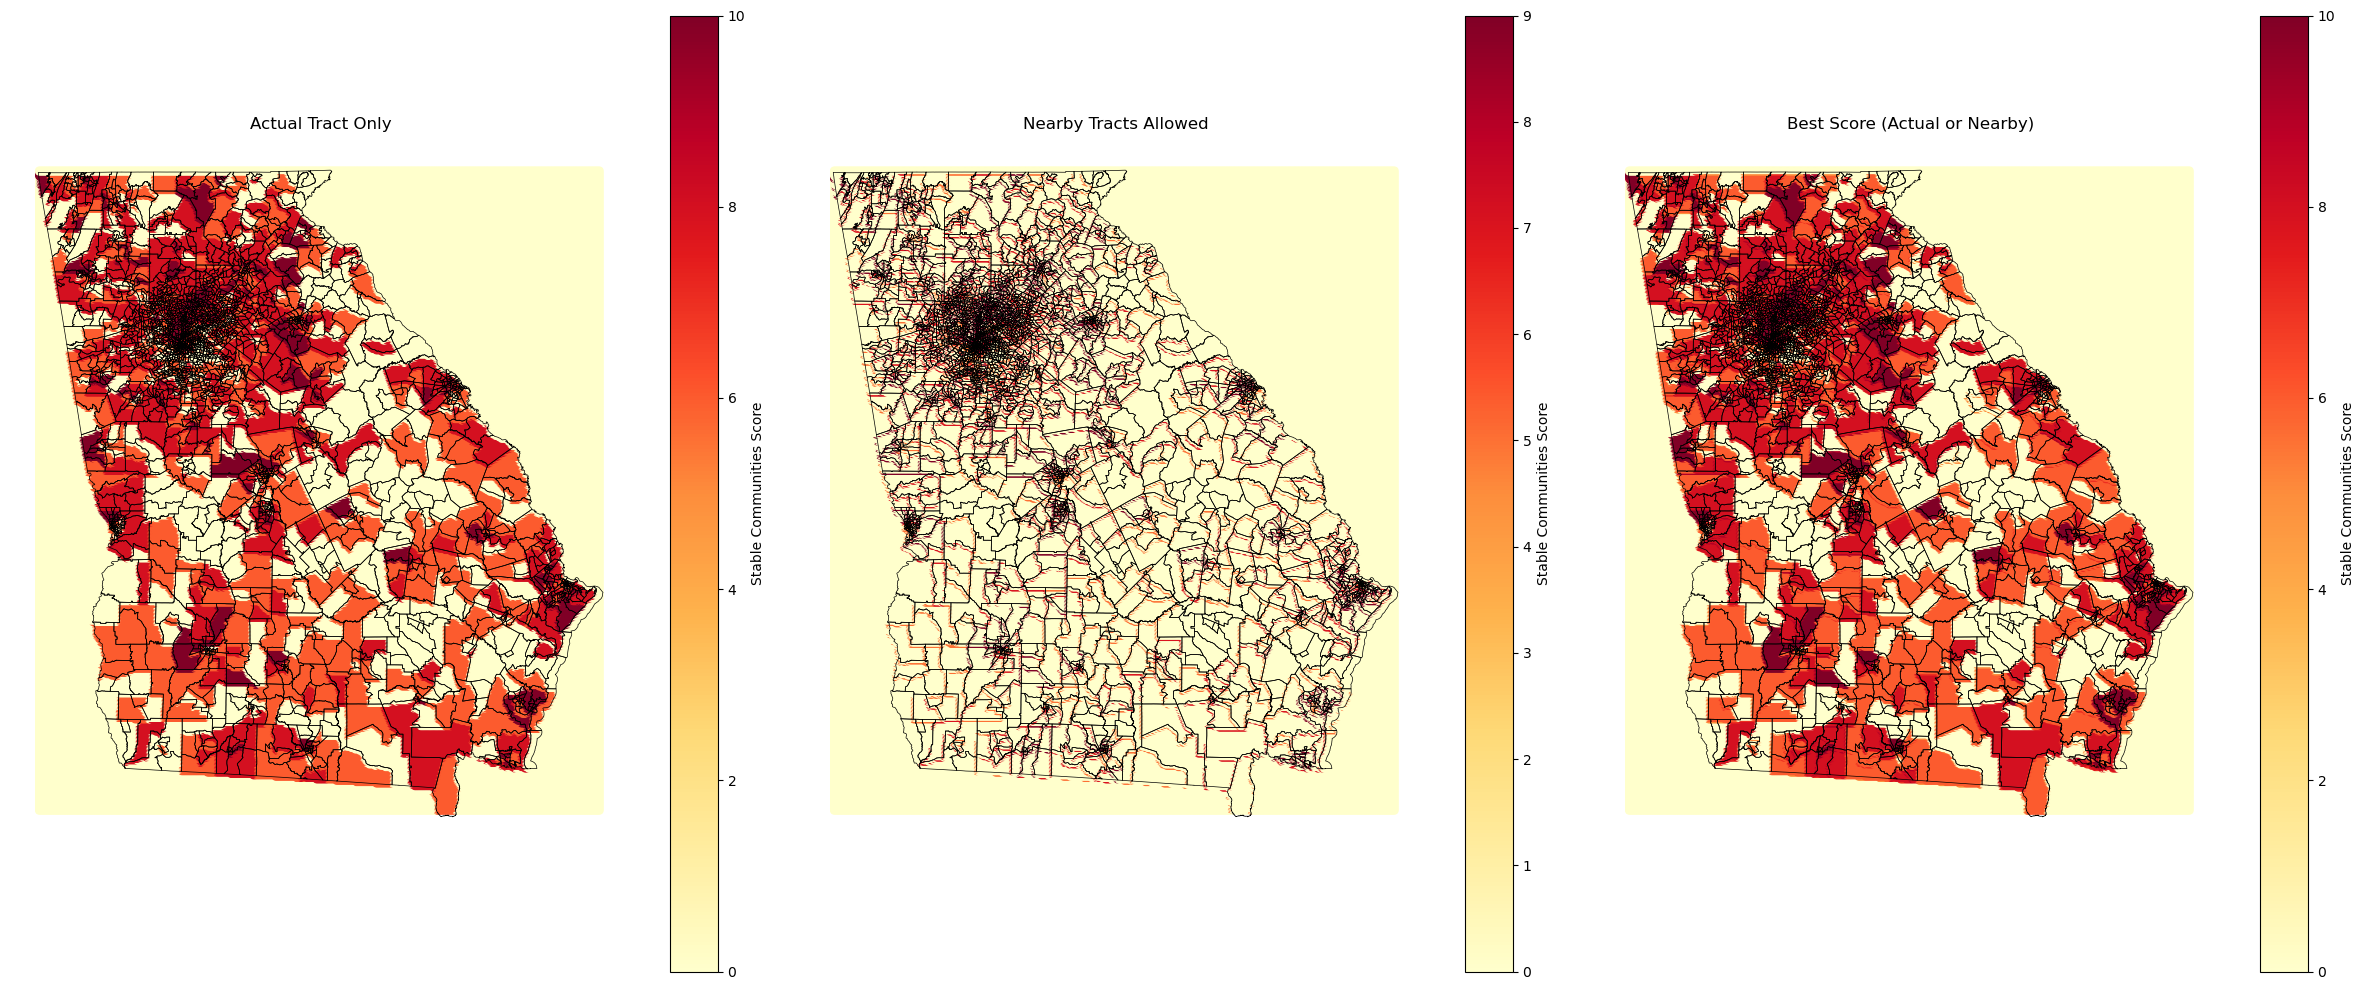

In [108]:
fig, axes = plt.subplots(1, 3, figsize=(24, 10))

score_cols = ["use_only_actual_tract", "use_nearby_tract", "best_score"]
titles = [
    "Actual Tract Only",
    "Nearby Tracts Allowed",
    "Best Score (Actual or Nearby)"
]

for ax, score_col, title in zip(axes, score_cols, titles):
    gdf_wide.plot(
        column=score_col,
        cmap="YlOrRd",
        ax=ax,
        markersize=20,
        legend=True,
        legend_kwds={'label': "Stable Communities Score"},
    )
    ga_tracts.boundary.plot(ax=ax, color="black", linewidth=0.5)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [119]:
gdf_wide = gpd.GeoDataFrame(
    df_wide,
    geometry=gpd.points_from_xy(df_wide["lon"], df_wide["lat"]),
    crs="EPSG:4326"
)

# gdf_wide.to_file("../../data/map/stable_communities/stable_communities_scores_geo.geojson", driver="GeoJSON")

In [120]:
ga_tracts = ga_tracts.to_crs(gdf_wide.crs)


In [121]:
# Dissolve tracts into a single Georgia boundary polygon
ga_boundary = ga_tracts.dissolve()

# Spatial filter: keep only points inside Georgia
gdf_ga_only = gdf_wide[gdf_wide.within(ga_boundary.geometry.iloc[0])]

In [122]:
gdf_ga_only.to_file("../../data/map/stable_communities/stable_communities_scores_geo.geojson", driver="GeoJSON")

In [124]:
# Load your original GeoDataFrame (EPSG:4326)
gdf_new = gpd.read_file("../../data/map/stable_communities/stable_communities_scores_geo.geojson")

# Reproject to EPSG:3857 (Web Mercator) or EPSG:26916 (UTM Zone 16N)
gdf_proj = gdf_new.to_crs("EPSG:3857")  # or "EPSG:26916" for Georgia-specific UTM

# Save to GeoPackage or Shapefile for use in QGIS
gdf_proj.to_file("../../data/map/stable_communities/stable_communities_scores_3857.gpkg", driver="GPKG")

In [126]:
gdf_proj['geometry'].nunique()

147838

In [127]:
gdf_proj

,lat,lon,use_nearby_tract,use_only_actual_tract,best_score,geometry
0,30.4,-82.20,0.0,6.0,6.0,POINT (-9150462.143 3555070.434)
1,30.4,-82.19,0.0,6.0,6.0,POINT (-9149348.948 3555070.434)
2,30.4,-82.18,0.0,6.0,6.0,POINT (-9148235.753 3555070.434)
3,30.4,-82.17,0.0,6.0,6.0,POINT (-9147122.558 3555070.434)
4,30.4,-82.16,0.0,6.0,6.0,POINT (-9146009.364 3555070.434)
...,...,...,...,...,...,...
147833,35.0,-83.15,0.0,0.0,0.0,POINT (-9256215.659 4163881.144)
147834,35.0,-83.14,0.0,0.0,0.0,POINT (-9255102.465 4163881.144)
147835,35.0,-83.13,0.0,0.0,0.0,POINT (-9253989.27 4163881.144)
147836,35.0,-83.12,0.0,0.0,0.0,POINT (-9252876.075 4163881.144)
